# Paper Content Analytics

Extract insights on the review in form of quantitative meta analysis and visualizations based on the [Google-Spreadsheet](https://docs.google.com/spreadsheets/d/1uM_VpRDk2YLPrqe4KiA_20HWBWmcSw_f9orz6cuOieQ).

## TODO 

- [x] find same pipelines (methods in preprocessing) with different names and unify them
- [ ] method occurences for different fitnesses and online scores
- [x] method occurences in papers, not in pipelines
- [x] improve visuals: https://networkx.org/documentation/latest/auto_examples/index.html

In [1]:
#!pip install unidecode

In [2]:
#!pip install openpyxl

In [3]:
#!pip install networkx

In [4]:
import os
import sys
import time
from datetime import datetime
#  from unidecode import unidecode

import math
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', None)
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
TABLE_NAME = "Systematic Literature Review on Motion Artifact Removal of EEG Signals.xlsx"

## Load the Spreadsheets into separate DataFrames

In [6]:
dtypes = {
     'Publication Year': pd.Int64Dtype(),
     'Create Date': pd.DatetimeIndex
}
papers_passed_df = pd.read_excel(TABLE_NAME, engine='openpyxl', sheet_name="papers_passed", dtype=dtypes, 
                                  usecols=['Reference', 'Title', 'Authors', 'Publication Year', 'Create Date'])
papers_passed_df.set_index("Reference", inplace=True)
papers_passed_df.info()
papers_passed_df.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 81 entries, Hossain22 to Jung01
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Title             81 non-null     object        
 1   Authors           81 non-null     object        
 2   Publication Year  81 non-null     Int64         
 3   Create Date       81 non-null     datetime64[ns]
dtypes: Int64(1), datetime64[ns](1), object(2)
memory usage: 3.2+ KB


,Title,Authors,Publication Year,Create Date
Reference,,,,
Hossain22,Motion Artifacts Correction from Single-Channel EEG and fNIRS Signals Using Novel Wavelet Packet Decomposition in Combination with Canonical Correlation Analysis,"Hossain MS, Chowdhury MEH, Reaz MBI, Ali SHM, Bakar AAA, Kiranyaz S, Khandakar A, Alhatou M, Habib R, Hossain MM.",2022,2022-05-20
Abu22,Improved Cognitive Vigilance Assessment after Artifact Reduction with Wavelet Independent Component Analysis,"Abu Farha N, Al-Shargie F, Tariq U, Al-Nashash H.",2022,2022-04-23


### Pipelines

In [7]:
dtypes = {
    'is new': pd.Int64Dtype(),
    'EEG (#ch)': pd.Int64Dtype(),
    # 'Epoch width (s)': 'float64',  # no not possible here
    'fit score (0-2)': pd.Int64Dtype(),
    'online score (0-2)': pd.Int64Dtype()
}
pipelines_df = pd.read_excel(TABLE_NAME, engine='openpyxl', sheet_name="Pipelines", header=1, 
                             na_values="-", dtype=dtypes, skipfooter=1)
pipelines_df = pipelines_df[~pipelines_df["Pipeline ID (unique per paper)"].isnull()]
pipelines_df.rename(columns={
    "Pipeline ID (unique per paper)": "Pipeline",
    "Filter (HP, LP, BP, BR)": "filter"}, inplace=True)
pipelines_df.set_index(["Reference", "Pipeline"], inplace=True)
print(pipelines_df.shape)
# TODO check if Bruhn02 is shown and needed? All fields "Pipeline ID (unique per paper)" must be provided
pipelines_df.tail(2)

(293, 59)


,,is new,EEG (#ch),"electrode type (w,g,d)",MEG,ECG,EMG,Others,filter,MA,AF,Other,Epoch width (s),Feature Extraction (#),Fourier Transf.,Wavelet Transf.,Welch,LSP,PCC,CCA,ICA,NMF,PCA,t-SNE,EMD,IVA,CSP,Other.1,Linear Regression,DA,SVM,Spacial sph. spline,GMM,Other.2,Autoencoder,GAN,Other.3,MARA,DSS,DFA,FASTER,ADJUST,HAPPE,ERASE,Other.4,DA.1,KNN,KMC,ED,NB,DT,RF,SVM.1,NN,GMM.1,MEC,Other.5,fit score (0-2),online score (0-2),details
Reference,Pipeline,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Iriarte03,HF_LF_NOTCH,0,64,NaN,NaN,NaN,NaN,NaN,1: HF (35 Hz; IIR order 4) + LF (0.3 Hz; IIR order 2) + NOTCH (50 Hz),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,NaN
Jung01,ICA,0,29,NaN,NaN,NaN,NaN,NaN,1: BP 0.1-50 Hz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,"It is averaged across multiple trials and even persons, therefore not applicable in this form"


### Pipeline Results

In [8]:
dtypes = {
     'Reference': 'category',
     # 'Setup ID': 'int32',  # only possible if they are non-floats
     # 'Data ID': 'int32', 
     'Metric': 'category',
     'Pipeline': 'category',
     'rank': 'float64'  # we break ties evenly
}

results_df = pd.read_excel(TABLE_NAME, engine='openpyxl', sheet_name="Results", 
                           na_values="-", header=1, dtype=dtypes, 
                           converters={"Setup ID": lambda x: str(x), "Data ID": lambda x: str(x)})
results_df.rename(columns=
                  {"rank in paper": "rank", 
                   "Pipeline ID (per paper)": "Pipeline"
                  }, inplace=True)
# results_df = results_df.loc[results_df.index.dropna()]
results_df = results_df.loc[results_df["Pipeline"].dropna().index]  # drop rows with NaN-Pipeline
results_df.drop(columns="details", inplace=True)
results_df["Setup ID"] = results_df["Setup ID"].astype(np.int32)
results_df["Data ID"] = results_df["Data ID"].astype(np.int32)
assert results_df[results_df["Metric"].isna()].shape[0] == 0  # should be empty
# results_df.dropna(inplace=True)
results_df.info()
results_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 782 entries, 0 to 808
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Reference  782 non-null    category
 1   Setup ID   782 non-null    int32   
 2   Data ID    782 non-null    int32   
 3   Metric     782 non-null    category
 4   Pipeline   782 non-null    object  
 5   rank       780 non-null    float64 
dtypes: category(2), float64(1), int32(2), object(1)
memory usage: 31.2+ KB


,Reference,Setup ID,Data ID,Metric,Pipeline,rank
316,Saba-Sadiya21,2,2,Cohen's K,LOF,8.0
101,Soghoyan21,6,1,ROC-AUC,LR,1.0
361,Leach20,1,2,Reliability,original ADJUST,3.5
531,Gabard-Durnam18,1,1,"average percent of artifact level retained, average percent of EEG signal retained",SASICA,3.5
640,DelPozo-Banos17,1,1,TAR,None-WithoutLCF,8.0


In [9]:
# Merge Pipelines with their results
results_df = results_df.merge(
    right=pipelines_df, how="outer", 
    left_on=["Reference", "Pipeline"], right_on=["Reference", "Pipeline"])
# drop missing
results_df = results_df[~results_df["rank"].isnull()]
print(results_df.shape)

(780, 65)


In [10]:
dtypes = {
     'Publication Year': pd.Int64Dtype(),
     'Create Date': pd.DatetimeIndex
}
papers_passed_df = pd.read_excel(TABLE_NAME, engine='openpyxl', sheet_name="papers_passed", dtype=dtypes, 
                                  usecols=['Reference', 'Title', 'Authors', 'Publication Year', 'Create Date'])
papers_passed_df.set_index("Reference", inplace=True)
papers_passed_df.info()
papers_passed_df.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 81 entries, Hossain22 to Jung01
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Title             81 non-null     object        
 1   Authors           81 non-null     object        
 2   Publication Year  81 non-null     Int64         
 3   Create Date       81 non-null     datetime64[ns]
dtypes: Int64(1), datetime64[ns](1), object(2)
memory usage: 3.2+ KB


,Title,Authors,Publication Year,Create Date
Reference,,,,
Hossain22,Motion Artifacts Correction from Single-Channel EEG and fNIRS Signals Using Novel Wavelet Packet Decomposition in Combination with Canonical Correlation Analysis,"Hossain MS, Chowdhury MEH, Reaz MBI, Ali SHM, Bakar AAA, Kiranyaz S, Khandakar A, Alhatou M, Habib R, Hossain MM.",2022,2022-05-20
Abu22,Improved Cognitive Vigilance Assessment after Artifact Reduction with Wavelet Independent Component Analysis,"Abu Farha N, Al-Shargie F, Tariq U, Al-Nashash H.",2022,2022-04-23


In [11]:
dtypes = {
     'Journal/Book': 'category',
     # 'reader': 'category',
     # 'excluded': 'int64',  # in converter (or with pd.Int64Dtype()
     'mental strategy': 'category',
     'framework': 'category',
     'open code': 'category'
}

papers_annotated_df = pd.read_excel(TABLE_NAME, engine='openpyxl', sheet_name="papers_annotated", 
                                    dtype=dtypes, converters={'excluded': lambda x: 0 if pd.isna(x) else int(x)})
papers_annotated_df = papers_annotated_df[~papers_annotated_df["reader"].isnull()]
papers_annotated_df.rename(columns={
    "sample (size, sex, age group, health status)": "sample",
    "open code (yes, no, -)": "open code"}, inplace=True)
papers_annotated_df.set_index("Reference", inplace=True)

In [12]:
# Merge with papers_passed
papers_annotated_df = papers_annotated_df.merge(papers_passed_df, how='outer')
papers_annotated_df.info()
papers_annotated_df.head(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84 entries, 0 to 83
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Index                   76 non-null     float64       
 1   Title                   82 non-null     object        
 2   Authors                 82 non-null     object        
 3   Journal/Book            75 non-null     category      
 4   reader                  77 non-null     object        
 5   mental strategy         74 non-null     category      
 6   objective               75 non-null     object        
 7   data acquisition        75 non-null     object        
 8   sample                  75 non-null     object        
 9   #sample                 71 non-null     object        
 10  evaluation metrics      74 non-null     object        
 11  framework               73 non-null     category      
 12  open code               74 non-null     object      

,Index,Title,Authors,Journal/Book,reader,mental strategy,objective,data acquisition,sample,#sample,evaluation metrics,framework,open code,Innovation / Finding,further work suggested,Additional information,Publication Year,Create Date
0,8.0,Motion Artifacts Correction from Single-Channel EEG and fNIRS Signals Using Novel Wavelet Packet Decomposition in Combination with Canonical Correlation Analysis,"Hossain MS, Chowdhury MEH, Reaz MBI, Ali SHM, Bakar AAA, Kiranyaz S, Khandakar A, Alhatou M, Habib R, Hossain MM.",Sensors (Basel),mst,-,"proposes 2 methods: (i) Wavelet packet decomposition (WPD) and (ii) WPD in combination with canonical correlation analysis (WPD-CCA), for motion artifact correction from single-channel EEG and compares it to multiple existing variants in benchmark tests","Single channel EEG with ground truth reference (second EEG + accelerometer used as ground truth). 23 sets of EEG recordings, sampled at 2048 Hz, later downsampled to 256 Hz",collected from six patients\nin four different sessions,6,"SNR, average percentage reduction in artifacts",Matlab,no,"Proposed WPD algorithms were investigated by 18 different approaches / modalities where four different wavelet packet families namely Daubechies, Symlet, Coiflet, and Fejer-Korovkin wavelet packet families","The paper describes the disadvantages of many existing methods like e.g. DWT, EMD, EEMD, VMD, DWT-ICA, EMD-ICA, EEMD-ICA, EMD-CCA, EEMD-CCA, VMD-CCA,.. BUT the paper does not show direct comparision of performance of these existing methods and the proposed variants of WPD and WPD-CCA","Would benefit from largely comparing DWT, EMD, EEMD, VMD, DWT-ICA, EMD-ICA, EEMD-ICA, EMD-CCA, EEMD-CCA, VMD-CCA with proposed WPD and WPD-CCA methods",2022,2022-05-20


In [13]:
dtypes = {
    'is new': pd.Int64Dtype(),
    'EEG (#ch)': pd.Int64Dtype(),
    # 'Epoch width (s)': 'float64',
    'fit score (0-2)': pd.Int64Dtype(),
    'online score (in [0,1,2])': pd.Int64Dtype()
}
pipelines_df = pd.read_excel(TABLE_NAME, engine='openpyxl', sheet_name="Pipelines", header=1, 
                             na_values="-", dtype=dtypes)
# pipelines_df = pipelines_df[~pipelines_df["is new"].isnull()]
pipelines_df.rename(columns={
    "Pipeline ID (unique per paper)": "Pipeline",
    "Filter (HP, LP, BP, BR)": "filter"}, inplace=True)
pipelines_df.set_index(["Reference", "Pipeline"], inplace=True)
pipelines_df.head(1)

,,is new,EEG (#ch),"electrode type (w,g,d)",MEG,ECG,EMG,Others,filter,MA,AF,Other,Epoch width (s),Feature Extraction (#),Fourier Transf.,Wavelet Transf.,Welch,LSP,PCC,CCA,ICA,NMF,PCA,t-SNE,EMD,IVA,CSP,Other.1,Linear Regression,DA,SVM,Spacial sph. spline,GMM,Other.2,Autoencoder,GAN,Other.3,MARA,DSS,DFA,FASTER,ADJUST,HAPPE,ERASE,Other.4,DA.1,KNN,KMC,ED,NB,DT,RF,SVM.1,NN,GMM.1,MEC,Other.5,fit score (0-2),online score (0-2),details
Reference,Pipeline,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Hossain22,WPD(db1),1,2,NaN,NaN,NaN,NaN,acc,1: NOTCH (3rd order Butterworth; center-f at 50 Hz) + Baseline Drift Removal,NaN,NaN,NaN,NaN,NaN,NaN,2: db1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,"Online score depends on concrete implementation of WPD but should be real-time compatible by nature. The authors claim novel approach, but questionable that they invented WPD."


In [14]:
# Show all pipelines that could fit and be online
scored_pipelines = pipelines_df[["fit score (0-2)", "online score (0-2)"]].dropna()
fit_pipelines = scored_pipelines[scored_pipelines["fit score (0-2)"] * scored_pipelines["online score (0-2)"] > 0]
fit_pipelines.sample(3)

,,fit score (0-2),online score (0-2)
Reference,Pipeline,,
Val-Calvo19,ICA-W-DELTA,1,2.0
Rosanne21,AF-RF: wICA,2,1.0
Lin18,CCA+GMM,1,1.0


In [15]:
dtypes = {
     'Reference': 'category',
     'Setup ID': 'category',  # only possible if they are non-floats
     'Data ID': 'category',
     'Metric': 'category',
     'Pipeline': 'category',
     'rank': 'float64'  # we break ties evenly
}

results_df = pd.read_excel(TABLE_NAME, engine='openpyxl', sheet_name="Results", header=1, dtype=dtypes, na_values="-")
results_df.rename(columns={"rank in paper": "rank", "Pipeline ID (per paper)": "Pipeline"}, inplace=True)
# results_df = results_df.loc[results_df.index.dropna()]
results_df = results_df.loc[results_df["Pipeline"].dropna().index]  # drop rows with NaN-Pipeline
results_df.drop(columns="details", inplace=True)
# results_df.dropna(inplace=True)
results_df.info()
results_df.sample(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 782 entries, 0 to 808
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Reference  782 non-null    category
 1   Setup ID   782 non-null    category
 2   Data ID    782 non-null    category
 3   Metric     782 non-null    category
 4   Pipeline   782 non-null    object  
 5   rank       780 non-null    float64 
dtypes: category(4), float64(1), object(1)
memory usage: 26.7+ KB


,Reference,Setup ID,Data ID,Metric,Pipeline,rank
454,Saavedra19,2,1,Accuracy,xDAWN,2.0
279,Saba-Sadiya21,1,2,Cohen's K,LSCP (2*HBOS+OCSVM),2.0
439,Val-Calvo19,1,1,Mutual Information,EAWICA-ALL,3.0


In [16]:
results_df = results_df.merge(pipelines_df, how="outer",
                              left_on=("Reference", "Pipeline"), 
                              right_on=("Reference", "Pipeline"))

## Check the validity of the ranks

In [17]:
mean_check_df = results_df.groupby(["Reference", "Setup ID", "Data ID", "Metric"]).agg(
    {"rank": ["mean", "count"]}
    ).dropna().droplevel(level=0, axis=1)
assert np.all(mean_check_df["count"] / 2.0 + 0.5 == mean_check_df["mean"])
# mean_check_df.loc[mean_check_df["count"] / 2.0 + 0.5 != mean_check_df["mean"]]
mean_check_df.head()

mean  count
Reference Setup ID Data ID Metric                                         
Abu22     1        1       Accuracy, Specificity, Sensitivity   5.5     10
Arad18    1        1       group average, SD                    1.5      2
Beach21   1        1       visual                               2.0      3
                   2       visual                               2.0      3
Benda19   1        1       peak detection efficacy              1.5      2

## Analysis

In [18]:
results_df.columns[13:51]

Index(['filter', 'MA', 'AF', 'Other', 'Epoch width (s)', 'Feature Extraction (#)', 'Fourier Transf.', 'Wavelet Transf.', 'Welch', 'LSP', 'PCC', 'CCA', 'ICA', 'NMF', 'PCA', 't-SNE', 'EMD', 'IVA', 'CSP', 'Other.1', 'Linear Regression', 'DA', 'SVM', 'Spacial sph. spline', 'GMM', 'Other.2', 'Autoencoder', 'GAN', 'Other.3', 'MARA', 'DSS', 'DFA', 'FASTER', 'ADJUST', 'HAPPE', 'ERASE', 'Other.4', 'DA.1'], dtype='object')

In [19]:
def string_concat(x):
    return ", ".join(x)


### Calculate the Average Normalize Rank over all Filters, Aggregations, Decompositions, Detection, Correction and Special algorithm

### Encoding of the Pipeline

Using a binary approach for each category

In [20]:
def encode_field(row):
    encoding = ""
    for col in ['filter', 'MA', 'AF', 'Other', 'Epoch width (s)', 'Feature Extraction (#)', 'Fourier Transf.', 'Wavelet Transf.', 'Welch', 'LSP', 'PCC', 'CCA', 'ICA', 'NMF', 'PCA', 't-SNE', 'EMD', 'IVA', 'CSP', 'Other.1', 'Linear Regression', 'DA', 'SVM', 'Spacial sph. spline', 'GMM', 'Other.2', 'Autoencoder', 'GAN', 'Other.3', 'MARA', 'DSS', 'DFA', 'FASTER', 'ADJUST', 'HAPPE', 'ERASE', 'Other.4']:
        if str(row[col]) == "nan":
            encoding += "0"
        else:
            encoding += "1"
    return encoding
    
results_df["Pipeline_encoding"] = results_df.apply(encode_field, axis=1)
results_df[["Reference", "Setup ID", "Data ID", "Metric", "Pipeline", "Pipeline_encoding", "rank"]].sample(3)

,Reference,Setup ID,Data ID,Metric,Pipeline,Pipeline_encoding,rank
713,Chen14,1,1,SNR,EEMD-IVA,1000000000000000110000000000000000000,2.5
754,Yong12,3,1,TPR,ASWTD-Hard,0111111100000000000001000000000000000,6.0
606,Delisle-Rodriguez17,2,2,F1(%),CSP,1000110000000000001000000000000000000,6.5


### Normalize rank for each "Reference", "Setup ID", "Data ID", "Metric": rank_norm

From 0-1.

In [21]:
# normalize the ranks
for idx, group in results_df.groupby(["Reference", "Setup ID", "Data ID", "Metric"]):
    max_rank = group["rank"].max()
    results_df.loc[group.index, "rank_norm"] = (group["rank"] - 1) / (max_rank - 1)
results_df[["Reference", "Setup ID", "Data ID", "Metric", "Pipeline", "Pipeline_encoding", "rank", "rank_norm"]].sample(3)

,Reference,Setup ID,Data ID,Metric,Pipeline,Pipeline_encoding,rank,rank_norm
728,Yong12,3,1,TPR,Ignore,0101011000000000000001000000000000000,7.0,0.666667
97,Soghoyan21,5,1,PR-AUC,LR,1000110000001000000010000000000000000,2.0,0.500000
298,Saba-Sadiya21,1,2,Cohen's K,PCA,0000100000000010000000000000000000000,5.0,0.444444


### Average rank over each Setup, Data and Metric for each "Reference" and "Pipeline"

Average rank_norm in each Reference

In [22]:
# grouping by Reference and Pipeline is okay
results_df_normed = results_df.groupby(["Reference", "Pipeline_encoding", "Pipeline"], sort=False).agg({"rank_norm": "mean"})
results_df_normed["Pipeline"] = results_df_normed.index.map(lambda x: x[-1])
results_df_normed = results_df_normed.droplevel(2)
results_df_normed.sample(3)

,,rank_norm,Pipeline
Reference,Pipeline_encoding,,
Rosanne21,1001010000000000000000000000000001000,0.092593,AF-RF: ADJUST
Yong12,0101111100000000000001000000000000000,0.801465,SWT-SURE
Rosanne21,1000010000000000000000000000000001000,0.277778,RF: ADJUST


In [23]:
value_counts_map = results_df_normed["Pipeline"].value_counts()
results_df_normed["count"] = results_df_normed["Pipeline"].apply(lambda x: value_counts_map[x])
results_df_normed = results_df_normed[~results_df_normed["rank_norm"].isnull()]  # drop nas (only one entry)
results_df_normed.sample(3)

,,rank_norm,Pipeline,count
Reference,Pipeline_encoding,,,
Chen14,1000000000000000100100000000000000000,0.000000,EEMD-JBSS,1
Hossain22,1000000100010000000000000000000000000,0.118192,WPD(db2)-CCA,1
Cheveigne16,1000000000000000000100000000000000000,0.250000,STAR,1


### Average normalized pipeline rank over each pipeline encoding per reference

In [24]:
# grouping by Reference and Pipeline encoding
results_df_normed2 = results_df_normed.groupby(["Reference", "Pipeline_encoding"], sort=False).agg({"rank_norm": ["count", "mean"], "Pipeline": string_concat})
# results_df_normed["Pipeline"] = results_df_normed.index.map(lambda x: x[-1])
results_df_normed2.columns = ["rank_norm_count", "rank_norm_mean", "Pipelines"]
results_df_normed2.sample(3)

,,rank_norm_count,rank_norm_mean,Pipelines
Reference,Pipeline_encoding,,,
Mur19,0000100000001000000000000000010000000,1,0.666667,MARA
Delisle-Rodriguez17,1010110000100000000100000000000000000,3,0.409449,"Filter Ad WAR, Ad LAR, Ad WAR"
Flo22,1000100000000010000000010000001000000,1,0.375000,APICE+DSS


### Average normalized pipeline rank over all references

In [25]:
results_df_normed3 = results_df_normed2.groupby(["Pipeline_encoding"], sort=False).agg({"rank_norm_count": ["sum", "count"], "rank_norm_mean": "mean", "Pipelines": string_concat})
results_df_normed3.columns = ["pipeline_count", "reference_count", "mean_normalized_rank", "Pipelines"]
results_df_normed3.sort_values(by=["reference_count", "mean_normalized_rank"], ascending=(False, True), inplace=True)
print(results_df_normed3.shape)
results_df_normed3.head(15)

(126, 4)


,pipeline_count,reference_count,mean_normalized_rank,Pipelines
Pipeline_encoding,,,,
1000000000000000000000000000000000000,16,12,0.952381,"FIR, IIR, FFT, NOTCH, Original EEG, Original EEG, Original EEG, Original EEG, Gel, Original EEG, Dry, Original EEG, Original EEG, Original EEG, Original EEG, LP-FILTERING, Original EEG, HF_LF_NOTCH"
1000000000001000000000000000000000000,16,4,0.633333,"FastICA-SVM, FastICA-KNN, FastICA-DT, FastICA-DA, FastICA-NB, wICA-SVM, wICA-KNN, wICA-DT, wICA-DA, wICA-NB, None-WithoutLCF, IMICA, Infomax, FastICA, JADE, SCICA"
1000000000000000000100000000000000000,4,3,0.562500,"SSD, STAR, STAR+JD, SOBI"
0000000000000000000000000000000000000,4,3,0.593750,"Standard Pipeline, MADE, Original EEG, JD"
1000000000001000000000000000100001000,2,2,0.244048,"ADJUST, ADJUST-WithLCF"
1000000000010000100000000000000000000,3,2,0.316667,"EEMD-CCA, sEEMD-CCA, EEMD-CCA"
1000110000001000000000000000000000000,2,2,0.500000,"CR1, AMICA"
1000010000001010000000000000000000000,5,2,0.601852,"RF: ASR_wICA, SVM: ASR_wICA, LPM-Setup1, SVM-Setup1, LDA-Setup1"
1000101000000000000000000000000000000,4,2,0.833333,"FFT-DBN, FFT-SVM, Robust Method w/Bayes, Standard Method w/Jackknife"


### Calculate the Average Normalize Rank over all Decompositions methods

### Encoding of the Pipeline

Using a binary approach for each category

In [26]:
def encode_field(row):
    encoding = ""
    for col in ['Fourier Transf.', 'Wavelet Transf.', 'Welch', 'LSP', 'PCC', 'CCA', 'ICA', 'NMF', 'PCA', 't-SNE', 'EMD', 'IVA', 'CSP', 'Other.1',]:
        if str(row[col]) == "nan":
            encoding += "0"
        else:
            encoding += "1"
    return encoding
    
results_df["Pipeline_encoding"] = results_df.apply(encode_field, axis=1)
results_df[["Reference", "Setup ID", "Data ID", "Metric", "Pipeline", "Pipeline_encoding", "rank"]].sample(3)

,Reference,Setup ID,Data ID,Metric,Pipeline,Pipeline_encoding,rank
235,Rosanne21,1,1,accuracy,SVM: HAPPE,00000000000000,18.0
407,Nordin20,1,1,"Relative power (db), scalp map, dipole locations and ERSP plots",Single-Layer-AMICA,00000010000000,5.0
274,Saba-Sadiya21,2,1,Cohen's K,OCSVN,00000000000000,8.0


### Normalize rank for each "Reference", "Setup ID", "Data ID", "Metric": rank_norm

From 0-1.

In [27]:
# normalize the ranks
for idx, group in results_df.groupby(["Reference", "Setup ID", "Data ID", "Metric"]):
    max_rank = group["rank"].max()
    results_df.loc[group.index, "rank_norm"] = (group["rank"] - 1) / (max_rank - 1)
results_df[["Reference", "Setup ID", "Data ID", "Metric", "Pipeline", "Pipeline_encoding", "rank", "rank_norm"]].sample(3)

,Reference,Setup ID,Data ID,Metric,Pipeline,Pipeline_encoding,rank,rank_norm
549,Tamburro18,1,1,FOR,"Dry, 80 IC",00000010100000,2.0,0.200000
272,Saba-Sadiya21,1,2,Cohen's K,OCSVN,00000000000000,7.0,0.666667
413,Liu19,1,1,RRMSE,CCA,00000100000000,3.0,1.000000


### Average rank over each Setup, Data and Metric for each "Reference" and "Pipeline"

Average rank_norm in each Reference

In [28]:
# grouping by Reference and Pipeline is okay
results_df_normed = results_df.groupby(["Reference", "Pipeline_encoding", "Pipeline"], sort=False).agg({"rank_norm": "mean"})
results_df_normed["Pipeline"] = results_df_normed.index.map(lambda x: x[-1])
results_df_normed = results_df_normed.droplevel(2)
results_df_normed.sample(3)

,,rank_norm,Pipeline
Reference,Pipeline_encoding,,
Mur19,00000010000000,0.166667,UAR
Leach20,10000010000000,0.387037,ICLabel
Yong12,10000000000000,0.888889,Ignore


In [29]:
value_counts_map = results_df_normed["Pipeline"].value_counts()
results_df_normed["count"] = results_df_normed["Pipeline"].apply(lambda x: value_counts_map[x])
results_df_normed = results_df_normed[~results_df_normed["rank_norm"].isnull()]  # drop nas (only one entry)
results_df_normed.sample(5)

,,rank_norm,Pipeline,count
Reference,Pipeline_encoding,,,
Rosanne21,00000000000000,0.277778,RF: ADJUST,1
Saini20,00000000000001,0.000000,VMD-cross,1
Gwin10,00000000000000,1.000000,Original EEG,12
Hossain22,01000100000000,0.000000,WPD(db1)-CCA,1
Flo22,00000010100000,0.250000,APICE+wICA+iMARA,1


### Average normalized pipeline rank over each pipeline encoding per reference

In [30]:
# grouping by Reference and Pipeline encoding
results_df_normed2 = results_df_normed.groupby(["Reference", "Pipeline_encoding"], sort=False).agg({"rank_norm": ["count", "mean"], "Pipeline": string_concat})
# results_df_normed["Pipeline"] = results_df_normed.index.map(lambda x: x[-1])
results_df_normed2.columns = ["rank_norm_count", "rank_norm_mean", "Pipelines"]
results_df_normed2.sample(5)

,,rank_norm_count,rank_norm_mean,Pipelines
Reference,Pipeline_encoding,,,
Karpiel21,00000000000000,5,0.900000,"Original EEG, FIR, IIR, FFT, NOTCH"
Yong12,10000010000000,1,0.789744,ERICA
Liu19,00000100000000,1,1.000000,CCA
Boudet14,00000000000000,1,1.000000,LP-FILTERING
Yong12,10000000000001,2,0.629365,"SOBI, AMUSE"


### Average normalized pipeline rank over all references

In [31]:
results_df_normed3 = results_df_normed2.groupby(["Pipeline_encoding"], sort=False).agg({"rank_norm_count": ["sum", "count"], "rank_norm_mean": "mean", "Pipelines": string_concat})
results_df_normed3.columns = ["pipeline_count", "reference_count", "mean_normalized_rank", "Pipelines"]
results_df_normed3.sort_values(by=["reference_count", "mean_normalized_rank"], ascending=(False, True), inplace=True)
print(results_df_normed3.shape)
results_df_normed3.head(15)

(32, 4)


,pipeline_count,reference_count,mean_normalized_rank,Pipelines
Pipeline_encoding,,,,
00000000000000,56,23,0.809911,"Standard Pipeline, MADE, CRD, Original EEG, FIR, IIR, FFT, NOTCH, Original EEG, AF acc, AF gyro, distribution-based double-rejection, energy double-rejection, hybrid double-rejection, AF-RF: Original EEG, AF-RF: ADJUST, AF-RF: HAPPE, AF-SVM: Original EEG, AF-SVM: ADJUST, AF-SVM: HAPPE, RF: Original EEG, RF: ADJUST, RF: HAPPE, SVM: Original EEG, SVM: ADJUST, SVM: HAPPE, OCSVN, AUTO, VAE, GAAL, MGAAL, Original EEG, Original EEG, ERASE-Real-EMG, ERASE-Simulated-EMG, SuBAR, xDAWN, METS_SEWS_1, METS_SEWS_2, Original EEG, Original EEG, FASTER, FASTER-MARA, Gel, Original EEG, Dry, Original EEG, Original EEG, JD, Original EEG, Original EEG, Raw, Original EEG, LP-FILTERING, DETECT, Original EEG, channel-based artifact removal, HF_LF_NOTCH"
00000010000000,60,18,0.445411,"FastICA-SVM, FastICA-KNN, FastICA-DT, FastICA-DA, FastICA-NB, wICA-SVM, wICA-KNN, wICA-DT, wICA-DA, wICA-NB, MADE, HAPPE, LR, XGB, SVM, AF-RF: wICA, AF-SVM: wICA, RF: wICA, SVM: wICA, Conventional-ICA, Single-Layer-AMICA, Dual-Layer-AMICA, Noise-Cancel-AMICA, ASR-AMICA, ASR-merged-AMICA, UAR, MARA, SASICA, TDSEP, Infomax, FastICA, HP-TDSEP, HP-Infomax, HP-FastICA, Fourier-ICA, HAPPE, ICA-MARA, ADJUST, SASICA, CR1, None-WithLCF, ADJUST-WithLCF, FASTER-WithLCF, None-WithoutLCF, ADJUST-WithoutLCF, FASTER-WithoutLCF, Our Method, FASTER, ADJUST, Auto-mutual information, K-means with similarity, IMICA, Infomax, FastICA, JADE, AMICA, WICA, SCICA, IC-based artifact removal, JADE-ICA"
00000000100000,17,7,0.750827,"APICE, APICEa, APICE+DSS, AF-RF: ASR, AF-RF: ASR_ADJUST, AF-SVM: ASR, AF-SVM: ASR_ADJUST, RF: ASR, RF: ASR_ADJUST, SVM: ASR, SVM: ASR_ADJUST, PCA, ASR, rASR, ASR, PCA, ASR"
00000000000001,13,6,0.432734,"HBOS, LOF, ABOD, LSCP (2*HBOS+OCSVM), VMD-cross, SSD, Filter WAR, LAR, WAR, Riemann Kernel, STAR, STAR+JD, SOBI"
00000010100000,15,5,0.457672,"APICE+wICA+iMARA, AF-RF: ASR_wICA, AF-SVM: ASR_wICA, RF: ASR_wICA, SVM: ASR_wICA, ASR, Gel, 20 IC, Gel, 50 IC, Gel, 80 IC, Dry, 20 IC, Dry, 50 IC, Dry, 80 IC, LPM-Setup1, SVM-Setup1, LDA-Setup1"
10000000000000,9,5,0.850000,"No correction, MC-Wiener-Filtered, MC-Wiener-Unfiltered, FFT-DBN, FFT-SVM, Robust Method w/Bayes, Standard Method w/Jackknife, Ignore, Reject"
00000100001000,8,4,0.383780,"EEMD-CCA, sEEMD-CCA, EEMD-CCA, EEMD-CCA-2EMG, EEMD-CCA-4EMG, EEMD-CCA-8EMG, EEMD-CCA, EEMD-CCA"
01000010000000,9,3,0.630952,"EAWICA-ALL, ICA-W-ALL, EAWICA-DELTA, ICA-W-DELTA, Linear dynamic system, Savetzky-Golay, wICA, ICAW-WithLCF, ICAW-WithoutLCF"
10000010000000,5,3,0.736087,"adjusted ADJUST, original ADJUST, ICLabel, AMICA, ERICA"


### Mean normalized rank per method

In [32]:
N_PAPER_THRESHOLD = 5
from IPython.display import display, Markdown

# count the occurences of types in all pipelines
# TODO could be done for different fitnesses and online scores
# TODO MultiIndex with algorithm type and method
print(f'Number of occurences of each algorithm in {len(results_df.groupby("Reference").agg("count"))} papers and {len(results_df.groupby(["Reference", "Pipeline"]).agg("count"))} pipelines with mean ranks:\n')


keys = [key for key in results_df.columns[13:-17] if not key.startswith("Other")]
df_keys = pd.DataFrame(columns=["#papers", "#pipelines", "mean normalized rank"], index=keys)
for key in keys:
    df_ = results_df[~results_df[key].isnull()]
    means = df_.groupby("Reference").agg({"rank_norm": "mean"})
    df_keys.loc[key, "#papers"] = len(means)
    df_keys.loc[key, "#pipelines"] = df_.groupby("Reference").agg({"rank_norm": "count"}).sum()[0]
    df_keys.loc[key, "mean normalized rank"] = means.mean()[0]

Number of occurences of each algorithm in 80 papers and 297 pipelines with mean ranks:



In [33]:
def permutation_test(x, y, runs=100):
    dist_orig = (x.mean() - y.mean())
    counter = 0
    for _ in range(runs):
        perm = np.random.permutation(np.concatenate([x, y]))
        x_mean = np.mean(perm[:len(x)])
        y_mean = np.mean(perm[len(x):])
        counter += dist_orig >= (x_mean - y_mean)
    p_value = counter / runs
    return p_value

permutation_test(np.random.normal(0, 1, 100), np.random.normal(0.5, 1, 100), runs=1000)

0.001

In [47]:
N_PAPER_THRESHOLD = 2
N_PIPELINE_THRESHOLD = 10
SIGNIFICANCE_LEVELS = (0.05, 0.01, 0.001)
from IPython.display import display, Markdown

# count the occurences of types in all pipelines
# TODO could be done for different fitnesses and online scores
# TODO MultiIndex with algorithm type and method
print(f'Number of occurences of each algorithm in {len(results_df.groupby("Reference").agg("count"))} papers and {len(results_df.groupby(["Reference", "Pipeline"]).agg("count"))} pipelines with mean ranks:\n')


keys = [key for key in results_df.columns[13:-17] if not key.startswith("Other")]

df_keys = pd.DataFrame(columns=pd.MultiIndex.from_tuples(list(zip(*[
    ["with Method", "with Method", "with Method", "without Method", "without Method", "without Method", "p-value"],
    ["#papers", "#pipelines", "mean normalized rank", "#papers", "#pipelines", "mean normalized rank", ""]]))), index=keys)

for key in keys:
    # Results with the method
    df_ = results_df[~results_df[key].isnull()]
    means_with = df_.groupby("Reference").agg({"rank_norm": "mean"}).dropna()
    df_keys.loc[key, ("with Method", "#papers")] = len(means_with)
    df_keys.loc[key, ("with Method", "#pipelines")] = df_.groupby("Reference").agg({"rank_norm": "count"}).sum()[0]
    df_keys.loc[key, ("with Method", "mean normalized rank")] = means_with.mean()[0]
    
    # Results without the method
    df_ = results_df[results_df[key].isnull()]
    means_wo = df_.groupby("Reference").agg({"rank_norm": "mean"}).dropna()
    df_keys.loc[key, ("without Method", "#papers")] = len(means_wo)
    df_keys.loc[key, ("without Method", "#pipelines")] = df_.groupby("Reference").agg({"rank_norm": "count"}).sum()[0]
    df_keys.loc[key, ("without Method", "mean normalized rank")] = means_wo.mean()[0]
    
    # Permutation test
    if len(means_with) > 0 and len(means_wo) > 0:
        p_value = permutation_test(means_with["rank_norm"].to_numpy(), 
                                   means_wo["rank_norm"].to_numpy(), runs=10_000)
        if p_value < SIGNIFICANCE_LEVELS[2]:
            df_keys.loc[key, ("p-value")] = f"***{p_value:.4f}"
        elif p_value < SIGNIFICANCE_LEVELS[1]:
            df_keys.loc[key, ("p-value")] = f"**{p_value:.4f}"
        elif p_value < SIGNIFICANCE_LEVELS[0]:
            df_keys.loc[key, ("p-value")] = f"*{p_value:.4f}"
        else:
            df_keys.loc[key, ("p-value")] = f"{p_value:.4f}"
            # df_keys.loc[key, ("p-value")] = p_value
    else:
        df_keys.loc[key, ("p-value")] = np.nan

df_keys_sorted = df_keys[np.logical_and(df_keys[("with Method", "#papers")] >= N_PAPER_THRESHOLD,
                                        df_keys[("with Method", "#pipelines")] >= N_PIPELINE_THRESHOLD)
                        ].sort_values(by=("with Method", "mean normalized rank"), ascending=True)
print("For each method in a pipeline, the numbers of papers and pipelines using and not using it are depicted with their respective mean normalized rank.", 
      "Additionally, a permutation test with 10,000 runs is applied that shows the p-value for using the respective method in a pipeline.")
df_keys_sorted

Number of occurences of each algorithm in 80 papers and 297 pipelines with mean ranks:

For each method in a pipeline, the numbers of papers and pipelines using and not using it are depicted with their respective mean normalized rank. Additionally, a permutation test with 10,000 runs is applied that shows the p-value for using the respective method in a pipeline.


with Method                                 without Method                                    p-value
                           #papers #pipelines mean normalized rank        #papers #pipelines mean normalized rank           
Linear Regression                3         45             0.251984             50        732             0.614836   **0.0014
AF                               2         37             0.288467             50        740             0.604473  ***0.0003
ADJUST                           7         50             0.407308             50        727             0.600791  ***0.0002
CCA                              9         55             0.459043             48        722             0.627259   **0.0017
SVM                              3         63              0.47134             50        714             0.607242    *0.0199
CSP                              3         20             0.492361             49        757             0.602551     0.0694
EMD                              7         70             0.496684             48        707             0.621198    *0.0218
Feature Extraction (#)          16        387             0.506317             39        390             0.618892    *0.0365
ICA                             28        283             0.510832             40        494              0.67759   **0.0042
Spacial sph. spline              3         56             0.524285             49        721             0.604257     0.2250
Epoch width (s)                 26        454             0.524471             32        323             0.662668   **0.0072
MARA                             4         12             0.552083             50        765             0.598606     0.3328
FASTER                           5         44             0.556833             49        733              0.59859     0.3280
Wavelet Transf.                  8        114             0.576702             47        663             0.609881     0.3262
filter                          45        577             0.631543             10        200             0.453794     0.9976
PCA                             12         91              0.66009             49        686             0.613942     0.7687
PCC                              2         22             0.687017             50        755             0.599799     0.7690
Fourier Transf.                  8        111             0.696575             43        666               0.5857     0.9510
MA                               2         51             0.753344             49        726              0.60036     0.8971
DA                               3         52             0.835563             48        725              0.58943     0.9839

In [78]:
N_PAPER_THRESHOLD = 2
N_PIPELINE_THRESHOLD = 10
SIGNIFICANCE_LEVELS = (0.05, 0.01, 0.001)
from IPython.display import display, Markdown

# count the occurences of types in all pipelines
# TODO could be done for different fitnesses and online scores
# TODO MultiIndex with algorithm type and method
print(f'Number of occurences of each algorithm in {len(results_df.groupby("Reference").agg("count"))} papers and {len(results_df.groupby(["Reference", "Pipeline"]).agg("count"))} pipelines with mean ranks:\n')


keys = [key for key in results_df.columns[13:-17] if not key.startswith("Other")]

df_keys = pd.DataFrame(columns=pd.MultiIndex.from_tuples(list(zip(*[
    ["with/without Method", "with/without Method", "with/without Method", "diff.", "p-value"],
    ["#papers", "#pipelines", "mean normalized rank", "", ""]]))), index=keys)

for key in keys:
    # Results with and without the method
    df_with = results_df[~results_df[key].isnull()]
    means_with = df_with.groupby("Reference").agg({"rank_norm": "mean"}).dropna()
    df_wo = results_df[results_df[key].isnull()]
    means_wo = df_wo.groupby("Reference").agg({"rank_norm": "mean"}).dropna()
    
    df_keys.loc[key, ("with/without Method", "#papers")] = f"{len(means_with)} / {len(means_wo)}"
    df_keys.loc[key, ("with/without Method", "#pipelines")] = f'{df_with.groupby("Reference").agg({"rank_norm": "count"}).sum()[0]} / {df_wo.groupby("Reference").agg({"rank_norm": "count"}).sum()[0]}'
    df_keys.loc[key, ("with/without Method", "mean normalized rank")] = f'{means_with.mean()[0]:.4f} / {means_wo.mean()[0]:.4f}'
    df_keys.loc[key, ("diff.")] = np.round(means_with.mean()[0] - means_wo.mean()[0], 4)

    # Permutation test
    if len(means_with) > 0 and len(means_wo) > 0:
        p_value = permutation_test(means_with["rank_norm"].to_numpy(), 
                                   means_wo["rank_norm"].to_numpy(), runs=10_000)
        if p_value < SIGNIFICANCE_LEVELS[2]:
            df_keys.loc[key, ("p-value")] = f"***{p_value:.4f}"
        elif p_value < SIGNIFICANCE_LEVELS[1]:
            df_keys.loc[key, ("p-value")] = f"**{p_value:.4f}"
        elif p_value < SIGNIFICANCE_LEVELS[0]:
            df_keys.loc[key, ("p-value")] = f"*{p_value:.4f}"
        else:
            df_keys.loc[key, ("p-value")] = f"{p_value:.4f}"
            # df_keys.loc[key, ("p-value")] = p_value
    else:
        df_keys.loc[key, ("p-value")] = np.nan

df_keys_sorted = df_keys[np.logical_and(df_keys[("with/without Method", "#papers")].apply(lambda x: int(x.split(" / ")[0])) >= N_PAPER_THRESHOLD,
                                        df_keys[("with/without Method", "#pipelines")].apply(lambda x: int(x.split(" / ")[0])) >= N_PIPELINE_THRESHOLD)
                        ].sort_values(by=("diff."), ascending=True)
print("For each method in a pipeline, the numbers of papers and pipelines using and not using it are depicted with their respective mean normalized rank.", 
      "Additionally, a permutation test with 10,000 runs is applied that shows the p-value for using the respective method in a pipeline.")
df_keys_sorted

Number of occurences of each algorithm in 80 papers and 297 pipelines with mean ranks:

For each method in a pipeline, the numbers of papers and pipelines using and not using it are depicted with their respective mean normalized rank. Additionally, a permutation test with 10,000 runs is applied that shows the p-value for using the respective method in a pipeline.


with/without Method                                   diff.    p-value
                                   #papers #pipelines mean normalized rank                   
Linear Regression                   3 / 50   45 / 732      0.2520 / 0.6148 -0.3629  ***0.0009
AF                                  2 / 50   37 / 740      0.2885 / 0.6045  -0.316  ***0.0005
ADJUST                              7 / 50   50 / 727      0.4073 / 0.6008 -0.1935  ***0.0006
CCA                                 9 / 48   55 / 722      0.4590 / 0.6273 -0.1682   **0.0022
ICA                                28 / 40  283 / 494      0.5108 / 0.6776 -0.1668   **0.0045
Epoch width (s)                    26 / 32  454 / 323      0.5245 / 0.6627 -0.1382   **0.0073
SVM                                 3 / 50   63 / 714      0.4713 / 0.6072 -0.1359    *0.0217
EMD                                 7 / 48   70 / 707      0.4967 / 0.6212 -0.1245    *0.0210
Feature Extraction (#)             16 / 39  387 / 390      0.5063 / 0.6189 -0.1126    *0.0351
CSP                                 3 / 49   20 / 757      0.4924 / 0.6026 -0.1102     0.0639
Spacial sph. spline                 3 / 49   56 / 721      0.5243 / 0.6043   -0.08     0.2315
MARA                                4 / 50   12 / 765      0.5521 / 0.5986 -0.0465     0.3268
FASTER                              5 / 49   44 / 733      0.5568 / 0.5986 -0.0418     0.3362
Wavelet Transf.                     8 / 47  114 / 663      0.5767 / 0.6099 -0.0332     0.3264
PCA                                12 / 49   91 / 686      0.6601 / 0.6139  0.0461     0.7733
PCC                                 2 / 50   22 / 755      0.6870 / 0.5998  0.0872     0.7480
Fourier Transf.                     8 / 43  111 / 666      0.6966 / 0.5857  0.1109     0.9543
MA                                  2 / 49   51 / 726      0.7533 / 0.6004   0.153     0.8938
filter                             45 / 10  577 / 200      0.6315 / 0.4538  0.1777     0.9976
DA                                  3 / 48   52 / 725      0.8356 / 0.5894  0.2461     0.9841

In [77]:
print(
    df_keys_sorted.rename(index={"Feature Extraction (#)": "Feature Extr."}
                         ).to_latex())

\begin{tabular}{llllll}
\toprule
{} & \multicolumn{3}{l}{with/without Method} &   diff. &    p-value \\
{} &             \#papers & \#pipelines & \multicolumn{3}{l}{mean normalized rank} \\
\midrule
Linear Regression   &              3 / 50 &   45 / 732 &      0.2520 / 0.6148 & -0.3629 &   **0.0010 \\
AF                  &              2 / 50 &   37 / 740 &      0.2885 / 0.6045 &  -0.316 &   **0.0010 \\
ADJUST              &              7 / 50 &   50 / 727 &      0.4073 / 0.6008 & -0.1935 &  ***0.0003 \\
CCA                 &              9 / 48 &   55 / 722 &      0.4590 / 0.6273 & -0.1682 &   **0.0032 \\
ICA                 &             28 / 40 &  283 / 494 &      0.5108 / 0.6776 & -0.1668 &   **0.0039 \\
Epoch width (s)     &             26 / 32 &  454 / 323 &      0.5245 / 0.6627 & -0.1382 &   **0.0065 \\
SVM                 &              3 / 50 &   63 / 714 &      0.4713 / 0.6072 & -0.1359 &    *0.0201 \\
EMD                 &              7 / 48 &   70 / 707 &      0.4967 / 0.

/tmp/ipykernel_1018692/1391621042.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  ).to_latex())


In [36]:
# df_keys_sorted = df_keys[df_keys["#papers"] >= N_PAPER_THRESHOLD].sort_values(by="mean normalized rank", ascending=True)


# table  = "Method | #papers | #pipelines | mean norm. rank \n"
# table += " --- | --- | --- | --- \n"
# for key, row in df_keys_sorted.iterrows():
#     table += f'{key} | {row["#papers"]} | {row["#pipelines"]} | {row["mean normalized rank"]:.4f} \n'
# print("Mean normalized score for all usages of selected methods, averaged accross each reference.")
# Markdown(table)

### Network construction

In [37]:
import networkx as nx

In [38]:
graph = nx.DiGraph()
for idx, group in results_df.groupby(["Reference", "Setup ID", "Data ID", "Metric"]):
    if len(group) > 3:
        # print(group)
        for idx_i, row_i in group.iterrows():
            for idx_j, row_j in group.iterrows():
                if idx_i > idx_j:
                    if row_i["rank"] <= row_j["rank"]:
                        graph.add_edge(row_i["Pipeline"], row_j["Pipeline"])
                    if row_j["rank"] <= row_i["rank"]:
                        graph.add_edge(row_j["Pipeline"], row_i["Pipeline"])
        break

In [39]:
graph.edges()

OutEdgeView([('FastICA-SVM', 'FastICA-KNN'), ('FastICA-SVM', 'FastICA-DT'), ('FastICA-SVM', 'FastICA-NB'), ('FastICA-SVM', 'wICA-SVM'), ('FastICA-SVM', 'wICA-KNN'), ('FastICA-SVM', 'wICA-DT'), ('FastICA-SVM', 'wICA-NB'), ('FastICA-KNN', 'FastICA-DT'), ('FastICA-KNN', 'FastICA-NB'), ('FastICA-KNN', 'wICA-KNN'), ('FastICA-KNN', 'wICA-DT'), ('FastICA-KNN', 'wICA-NB'), ('FastICA-DT', 'FastICA-NB'), ('FastICA-DT', 'wICA-DT'), ('FastICA-DT', 'wICA-NB'), ('FastICA-DA', 'FastICA-SVM'), ('FastICA-DA', 'FastICA-KNN'), ('FastICA-DA', 'FastICA-DT'), ('FastICA-DA', 'FastICA-NB'), ('FastICA-DA', 'wICA-SVM'), ('FastICA-DA', 'wICA-KNN'), ('FastICA-DA', 'wICA-DT'), ('FastICA-DA', 'wICA-DA'), ('FastICA-DA', 'wICA-NB'), ('wICA-SVM', 'FastICA-SVM'), ('wICA-SVM', 'FastICA-KNN'), ('wICA-SVM', 'FastICA-DT'), ('wICA-SVM', 'FastICA-NB'), ('wICA-SVM', 'wICA-KNN'), ('wICA-SVM', 'wICA-DT'), ('wICA-SVM', 'wICA-NB'), ('wICA-KNN', 'FastICA-KNN'), ('wICA-KNN', 'FastICA-DT'), ('wICA-KNN', 'FastICA-NB'), ('wICA-KNN', '

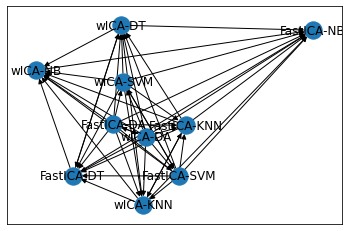

In [40]:
from matplotlib import pyplot as plt

plt.tight_layout()
nx.draw_networkx(graph, arrows=True)
# plt.savefig("g1.png", format="PNG")
plt.show()

In [41]:
graph = nx.DiGraph()

for idx, group in results_df.groupby(["Reference", "Setup ID", "Data ID", "Metric"]):
    for idx_i, row_i in group.iterrows():
        for idx_j, row_j in group.iterrows():
            if idx_i > idx_j:
                if row_i["rank"] <= row_j["rank"]:
                    graph.add_edge(row_i["Pipeline"], row_j["Pipeline"])
                if row_j["rank"] <= row_i["rank"]:
                    graph.add_edge(row_j["Pipeline"], row_i["Pipeline"])

print(f"The dominance graph has {len(graph.edges())} edges.")

The dominance graph has 1343 edges.


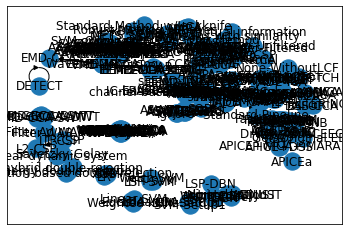

In [42]:
plt.tight_layout()
nx.draw_networkx(graph, arrows=True)
# plt.savefig("g1.png", format="PNG")
plt.show()

In [43]:
# pipe_dom_df = pd.DataFrame(index=list(graph.nodes), columns=["sup", "inf"])
# pipe_dom_df[:] = 0

# for sup, inf in graph.edges():
#     pipe_dom_df.loc[sup, "sup"] += 1
#     pipe_dom_df.loc[inf, "inf"] += 1
    
# pipe_dom_df["sum"] = pipe_dom_df["sup"] + pipe_dom_df["inf"]
# pipe_dom_df["diff"] = pipe_dom_df["sup"] - pipe_dom_df["inf"]
# pipe_dom_df["ratio"] = pipe_dom_df["sup"] / (pipe_dom_df["sup"] + pipe_dom_df["inf"])

# pipe_dom_df.sort_values("ratio", ascending=False)
# pipe_dom_df = pipe_dom_df.merge(pipeline_means, how="inner", left_index=True, right_on="Pipeline")
# pipe_dom_df